# Complete Layered BERT Architecture for Shakespeare Sonnets
## Trajectory Tortuosity Analysis with Three-Layer Prosodic Conditioning

This notebook presents a complete experimental design testing how different BERT architectures
capture semantic complexity in Shakespeare's 154 sonnets.

## Experimental Design

### Models Tested:
1. **bert-base-uncased** (Baseline - general modern English)
2. **EEBO-BERT** (Layer 1 - historical semantics 1595-1700)
3. **Poetry-BERT** (Current Layer 2 - poetry specialization, trained from base)
4. **Poetry-EEBO-BERT** (Proper Layer 2 - TO BE TRAINED on Colab)

### Conditioning Tested:
- **Semantic-only**: Pure BERT embeddings (768 dimensions)
- **+Prosody** (Layer 3): Embeddings augmented with prosodic features (768 + 4 dimensions)
  - Metrical deviation from iambic pentameter
  - Rhyme pair detection (Shakespearean sonnet scheme: ABAB CDCD EFEF GG)
  - Positional encoding (line position in sonnet)
  - Couplet marking (final 2 lines)

### Research Questions:
1. Does historical training (EEBO) change semantic representations?
2. Does poetry training change semantic representations?
3. Do prosodic constraints influence semantic trajectory?
4. How do these layers interact?

### Trajectory Tortuosity Metric:
```
tortuosity = cumulative_angular_deviation / euclidean_distance
```
- Measures semantic "turns" through 768-dimensional BERT embedding space
- Higher values = more complex semantic trajectory (more directional changes)
- Lower values = smoother semantic progression

## Setup

In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from pathlib import Path
import prosodic as p

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports complete")

✓ Imports complete


## Load Pre-Computed Results

Load all experimental results for comparison

In [11]:
# Load all results
results = {}

# Base BERT (includes both semantic and prosody in same file)
results['base_layer3'] = pd.read_csv('../results/shakespeare_sonnets_layer3_base_bert.csv')

# Semantic-only (no prosody)
results['eebo_semantic'] = pd.read_csv('../results/shakespeare_sonnets_eebo_bert_contextual.csv')
results['poetry_semantic'] = pd.read_csv('../results/shakespeare_sonnets_poetry_bert_contextual.csv')

# With prosody (Layer 3)
results['eebo_layer3'] = pd.read_csv('../results/shakespeare_sonnets_layer3_eebo_bert.csv')
results['poetry_layer3'] = pd.read_csv('../results/shakespeare_sonnets_layer3_poetry_bert.csv')

# Comparison
results['comparison'] = pd.read_csv('../results/eebo_vs_poetry_bert_contextual_comparison.csv')

print("✓ All results loaded")
print(f"  Base BERT (both): {len(results['base_layer3'])} sonnets")
print(f"  EEBO semantic: {len(results['eebo_semantic'])} sonnets")
print(f"  Poetry semantic: {len(results['poetry_semantic'])} sonnets")
print(f"  EEBO + prosody: {len(results['eebo_layer3'])} sonnets")
print(f"  Poetry + prosody: {len(results['poetry_layer3'])} sonnets")

✓ All results loaded
  Base BERT (both): 154 sonnets
  EEBO semantic: 154 sonnets
  Poetry semantic: 154 sonnets
  EEBO + prosody: 154 sonnets
  Poetry + prosody: 154 sonnets


## Summary Statistics

### Overall Tortuosity by Model and Conditioning

In [12]:
summary_data = []

# Base BERT
summary_data.append({
    'Model': 'Base BERT',
    'Conditioning': 'Semantic Only',
    'Mean': results['base_layer3']['semantic_tortuosity'].mean(),
    'SD': results['base_layer3']['semantic_tortuosity'].std(),
    'Min': results['base_layer3']['semantic_tortuosity'].min(),
    'Max': results['base_layer3']['semantic_tortuosity'].max()
})

summary_data.append({
    'Model': 'Base BERT',
    'Conditioning': '+ Prosody (Layer 3)',
    'Mean': results['base_layer3']['prosody_conditioned_tortuosity'].mean(),
    'SD': results['base_layer3']['prosody_conditioned_tortuosity'].std(),
    'Min': results['base_layer3']['prosody_conditioned_tortuosity'].min(),
    'Max': results['base_layer3']['prosody_conditioned_tortuosity'].max()
})

# EEBO-BERT
summary_data.append({
    'Model': 'EEBO-BERT',
    'Conditioning': 'Semantic Only',
    'Mean': results['eebo_semantic']['overall_tortuosity'].mean(),
    'SD': results['eebo_semantic']['overall_tortuosity'].std(),
    'Min': results['eebo_semantic']['overall_tortuosity'].min(),
    'Max': results['eebo_semantic']['overall_tortuosity'].max()
})

summary_data.append({
    'Model': 'EEBO-BERT',
    'Conditioning': '+ Prosody (Layer 3)',
    'Mean': results['eebo_layer3']['prosody_conditioned_tortuosity'].mean(),
    'SD': results['eebo_layer3']['prosody_conditioned_tortuosity'].std(),
    'Min': results['eebo_layer3']['prosody_conditioned_tortuosity'].min(),
    'Max': results['eebo_layer3']['prosody_conditioned_tortuosity'].max()
})

# Poetry-BERT
summary_data.append({
    'Model': 'Poetry-BERT',
    'Conditioning': 'Semantic Only',
    'Mean': results['poetry_semantic']['overall_tortuosity'].mean(),
    'SD': results['poetry_semantic']['overall_tortuosity'].std(),
    'Min': results['poetry_semantic']['overall_tortuosity'].min(),
    'Max': results['poetry_semantic']['overall_tortuosity'].max()
})

summary_data.append({
    'Model': 'Poetry-BERT',
    'Conditioning': '+ Prosody (Layer 3)',
    'Mean': results['poetry_layer3']['prosody_conditioned_tortuosity'].mean(),
    'SD': results['poetry_layer3']['prosody_conditioned_tortuosity'].std(),
    'Min': results['poetry_layer3']['prosody_conditioned_tortuosity'].min(),
    'Max': results['poetry_layer3']['prosody_conditioned_tortuosity'].max()
})

df_summary = pd.DataFrame(summary_data)

print("="*80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("\n" + "="*80)

EXPERIMENTAL RESULTS SUMMARY
      Model        Conditioning     Mean       SD      Min      Max
  Base BERT       Semantic Only 3.170677 0.424656 2.260798 4.466694
  Base BERT + Prosody (Layer 3) 3.104944 0.398563 2.234479 4.271949
  EEBO-BERT       Semantic Only 3.446670 0.364337 2.633465 4.562865
  EEBO-BERT + Prosody (Layer 3) 3.363907 0.338117 2.598413 4.350969
Poetry-BERT       Semantic Only 3.590874 0.352124 2.584819 4.572891
Poetry-BERT + Prosody (Layer 3) 3.498416 0.327624 2.545685 4.372206



## Visualization: Model Comparison

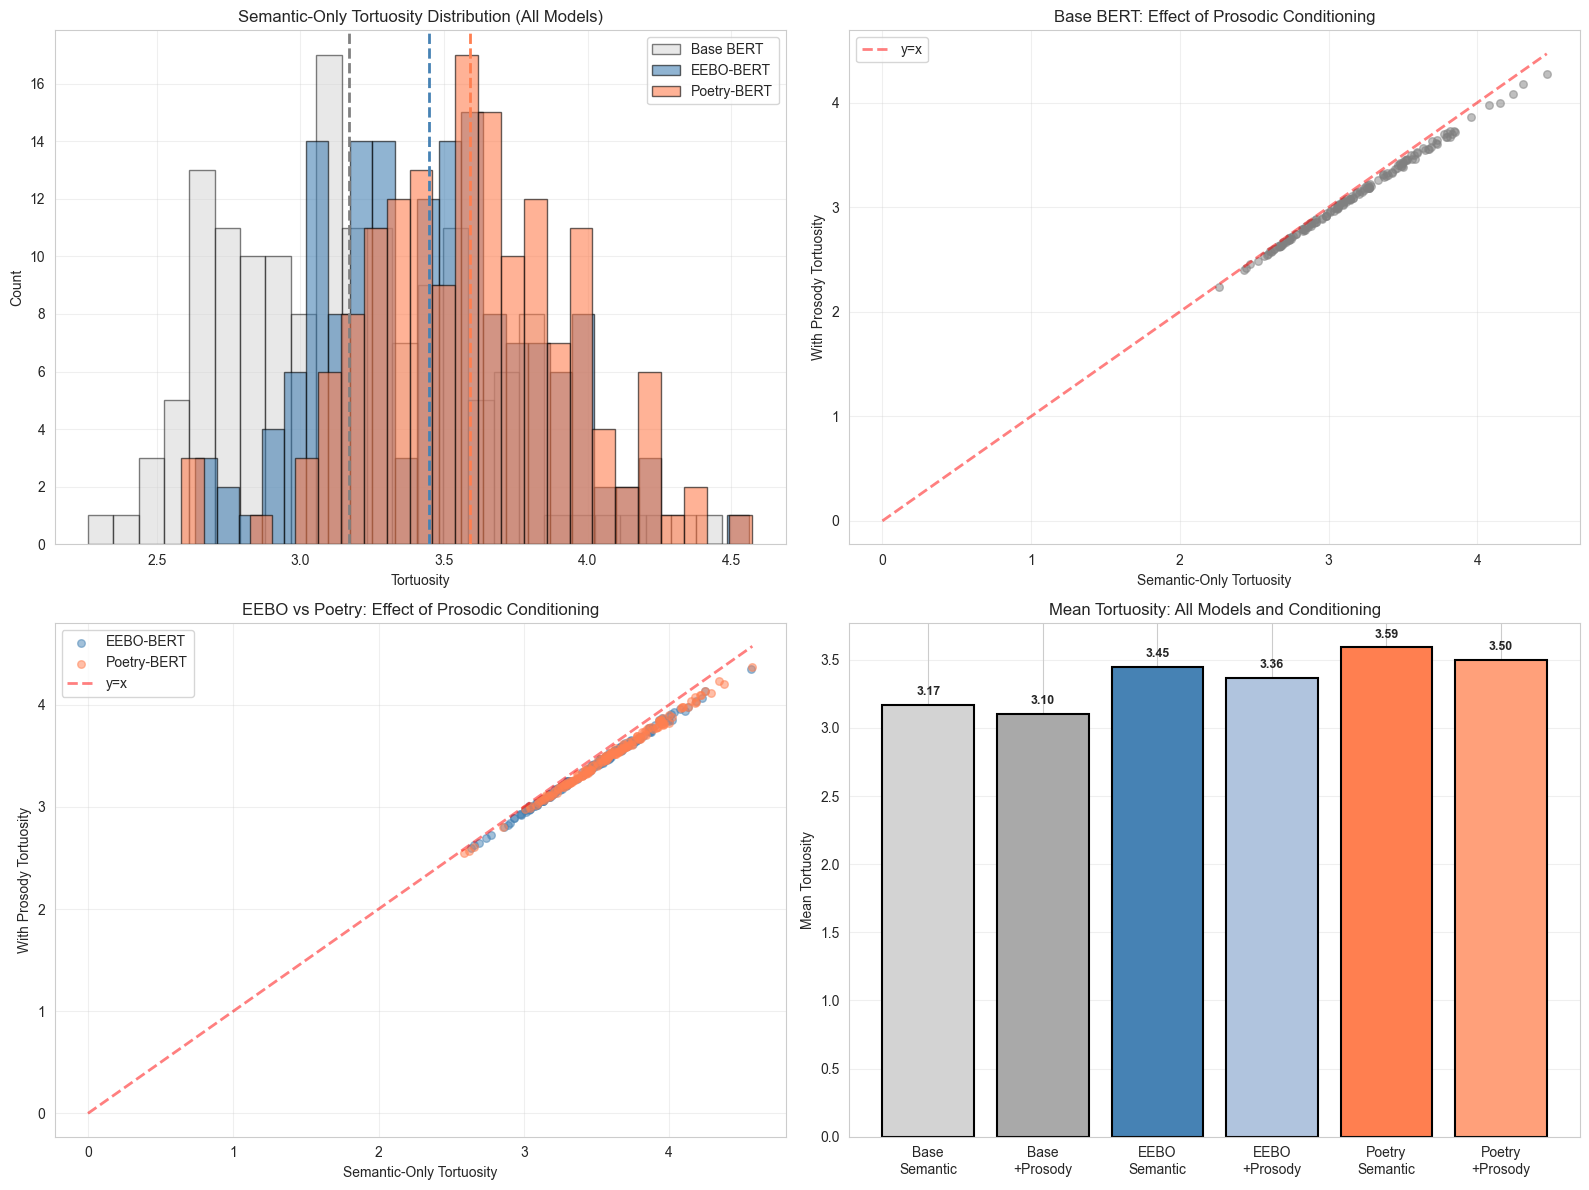

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison - Semantic only (all three models)
axes[0, 0].hist(results['base_layer3']['semantic_tortuosity'], bins=25, alpha=0.5, 
               label='Base BERT', edgecolor='black', color='lightgray')
axes[0, 0].hist(results['eebo_semantic']['overall_tortuosity'], bins=25, alpha=0.6, 
               label='EEBO-BERT', edgecolor='black', color='steelblue')
axes[0, 0].hist(results['poetry_semantic']['overall_tortuosity'], bins=25, alpha=0.6,
               label='Poetry-BERT', edgecolor='black', color='coral')
axes[0, 0].axvline(results['base_layer3']['semantic_tortuosity'].mean(), 
                  color='gray', linestyle='--', linewidth=2)
axes[0, 0].axvline(results['eebo_semantic']['overall_tortuosity'].mean(), 
                  color='steelblue', linestyle='--', linewidth=2)
axes[0, 0].axvline(results['poetry_semantic']['overall_tortuosity'].mean(),
                  color='coral', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Tortuosity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Semantic-Only Tortuosity Distribution (All Models)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Effect of prosody on Base BERT
axes[0, 1].scatter(results['base_layer3']['semantic_tortuosity'],
                  results['base_layer3']['prosody_conditioned_tortuosity'],
                  alpha=0.5, s=30, color='gray')
max_val = max(results['base_layer3']['semantic_tortuosity'].max(),
             results['base_layer3']['prosody_conditioned_tortuosity'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='y=x')
axes[0, 1].set_xlabel('Semantic-Only Tortuosity')
axes[0, 1].set_ylabel('With Prosody Tortuosity')
axes[0, 1].set_title('Base BERT: Effect of Prosodic Conditioning')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Effect of prosody comparison across models
axes[1, 0].scatter(results['eebo_layer3']['semantic_tortuosity'],
                  results['eebo_layer3']['prosody_conditioned_tortuosity'],
                  alpha=0.5, s=30, color='steelblue', label='EEBO-BERT')
axes[1, 0].scatter(results['poetry_layer3']['semantic_tortuosity'],
                  results['poetry_layer3']['prosody_conditioned_tortuosity'],
                  alpha=0.5, s=30, color='coral', label='Poetry-BERT')
max_val = max(results['eebo_layer3']['semantic_tortuosity'].max(),
             results['poetry_layer3']['semantic_tortuosity'].max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='y=x')
axes[1, 0].set_xlabel('Semantic-Only Tortuosity')
axes[1, 0].set_ylabel('With Prosody Tortuosity')
axes[1, 0].set_title('EEBO vs Poetry: Effect of Prosodic Conditioning')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Bar chart comparison - All models
models = ['Base\nSemantic', 'Base\n+Prosody', 
          'EEBO\nSemantic', 'EEBO\n+Prosody', 
          'Poetry\nSemantic', 'Poetry\n+Prosody']
means = [
    results['base_layer3']['semantic_tortuosity'].mean(),
    results['base_layer3']['prosody_conditioned_tortuosity'].mean(),
    results['eebo_semantic']['overall_tortuosity'].mean(),
    results['eebo_layer3']['prosody_conditioned_tortuosity'].mean(),
    results['poetry_semantic']['overall_tortuosity'].mean(),
    results['poetry_layer3']['prosody_conditioned_tortuosity'].mean()
]
colors = ['lightgray', 'darkgray', 'steelblue', 'lightsteelblue', 'coral', 'lightsalmon']
axes[1, 1].bar(models, means, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Mean Tortuosity')
axes[1, 1].set_title('Mean Tortuosity: All Models and Conditioning')
axes[1, 1].grid(alpha=0.3, axis='y')

# Add values on bars
for i, (model, mean) in enumerate(zip(models, means)):
    axes[1, 1].text(i, mean + 0.05, f'{mean:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## Couplet Analysis

Examine whether the final couplet is more or less complex than the average line in each sonnet

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive scatter plots for couplet analysis
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Base BERT', 'EEBO-BERT', 'Poetry-BERT'),
    horizontal_spacing=0.1
)

# Base BERT
fig.add_trace(
    go.Scatter(
        x=results['base_layer3']['semantic_tortuosity'],
        y=results['base_layer3']['couplet_tortuosity'] if 'couplet_tortuosity' in results['base_layer3'].columns else [0]*len(results['base_layer3']),
        mode='markers',
        marker=dict(size=8, color=results['base_layer3']['sonnet'], colorscale='Viridis', showscale=False),
        text=results['base_layer3']['sonnet'].apply(lambda x: f'Sonnet {x}'),
        hovertemplate='<b>%{text}</b><br>Mean Line: %{x:.3f}<br>Couplet: %{y:.3f}<extra></extra>',
        name='Base BERT'
    ),
    row=1, col=1
)

# EEBO-BERT
fig.add_trace(
    go.Scatter(
        x=results['eebo_semantic']['mean_line_tortuosity'],
        y=results['eebo_semantic']['couplet_tortuosity'],
        mode='markers',
        marker=dict(size=8, color=results['eebo_semantic']['sonnet'], colorscale='Viridis', showscale=False),
        text=results['eebo_semantic']['sonnet'].apply(lambda x: f'Sonnet {x}'),
        hovertemplate='<b>%{text}</b><br>Mean Line: %{x:.3f}<br>Couplet: %{y:.3f}<extra></extra>',
        name='EEBO-BERT'
    ),
    row=1, col=2
)

# Poetry-BERT
fig.add_trace(
    go.Scatter(
        x=results['poetry_semantic']['mean_line_tortuosity'],
        y=results['poetry_semantic']['couplet_tortuosity'],
        mode='markers',
        marker=dict(size=8, color=results['poetry_semantic']['sonnet'], colorscale='Viridis', showscale=True,
                   colorbar=dict(title="Sonnet", x=1.15)),
        text=results['poetry_semantic']['sonnet'].apply(lambda x: f'Sonnet {x}'),
        hovertemplate='<b>%{text}</b><br>Mean Line: %{x:.3f}<br>Couplet: %{y:.3f}<extra></extra>',
        name='Poetry-BERT'
    ),
    row=1, col=3
)

# Add y=x reference lines
for col in range(1, 4):
    if col == 1:
        max_val = max(results['base_layer3']['semantic_tortuosity'].max(), 
                     results['base_layer3']['couplet_tortuosity'].max() if 'couplet_tortuosity' in results['base_layer3'].columns else 0)
    elif col == 2:
        max_val = max(results['eebo_semantic']['mean_line_tortuosity'].max(), 
                     results['eebo_semantic']['couplet_tortuosity'].max())
    else:
        max_val = max(results['poetry_semantic']['mean_line_tortuosity'].max(), 
                     results['poetry_semantic']['couplet_tortuosity'].max())
    
    fig.add_trace(
        go.Scatter(
            x=[0, max_val],
            y=[0, max_val],
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=1, col=col
    )

# Update axes
fig.update_xaxes(title_text="Mean Line Tortuosity", row=1, col=1)
fig.update_xaxes(title_text="Mean Line Tortuosity", row=1, col=2)
fig.update_xaxes(title_text="Mean Line Tortuosity", row=1, col=3)

fig.update_yaxes(title_text="Couplet Tortuosity", row=1, col=1)
fig.update_yaxes(title_text="Couplet Tortuosity", row=1, col=2)
fig.update_yaxes(title_text="Couplet Tortuosity", row=1, col=3)

fig.update_layout(
    height=500,
    title_text="Couplet Complexity vs Mean Line Complexity (Hover to identify sonnets)",
    showlegend=False
)

fig.show()

# Statistics
print("\n" + "="*80)
print("COUPLET COMPLEXITY STATISTICS")
print("="*80)

# We need to check if base_layer3 has couplet data
if 'couplet_tortuosity' in results['base_layer3'].columns:
    base_high_couplet = (results['base_layer3']['couplet_tortuosity'] > results['base_layer3']['semantic_tortuosity']).sum()
    print(f"\nBase BERT:   {base_high_couplet} sonnets ({base_high_couplet/len(results['base_layer3'])*100:.1f}%) have couplets more complex than average line")

eebo_high_couplet = (results['eebo_semantic']['couplet_tortuosity'] > results['eebo_semantic']['mean_line_tortuosity']).sum()
print(f"EEBO-BERT:   {eebo_high_couplet} sonnets ({eebo_high_couplet/len(results['eebo_semantic'])*100:.1f}%) have couplets more complex than average line")

poetry_high_couplet = (results['poetry_semantic']['couplet_tortuosity'] > results['poetry_semantic']['mean_line_tortuosity']).sum()
print(f"Poetry-BERT: {poetry_high_couplet} sonnets ({poetry_high_couplet/len(results['poetry_semantic'])*100:.1f}%) have couplets more complex than average line")

print("\nInterpretation:")
print("- Points ABOVE the red line: couplet is more complex than average line")
print("- Points BELOW the red line: couplet is less complex than average line")
print("- Hover over points to identify specific sonnets")


COUPLET COMPLEXITY STATISTICS

Base BERT:   154 sonnets (100.0%) have couplets more complex than average line
EEBO-BERT:   53 sonnets (34.4%) have couplets more complex than average line
Poetry-BERT: 58 sonnets (37.7%) have couplets more complex than average line

Interpretation:
- Points ABOVE the red line: couplet is more complex than average line
- Points BELOW the red line: couplet is less complex than average line
- Hover over points to identify specific sonnets


In [15]:
# Load sonnets and extract couplets for labeling
sonnets_path = Path('../corpus_samples/shakespeare_sonnets_parsed.jsonl')
sonnets = []
with open(sonnets_path, 'r') as f:
    for line in f:
        sonnets.append(json.loads(line))

sonnet_lookup = {s['sonnet_number']: s for s in sonnets}

# Create a couplet text lookup (last 2 lines of each sonnet)
couplet_lookup = {}
for sonnet in sonnets:
    sonnet_num = sonnet['sonnet_number']
    lines = sonnet['lines']
    if len(lines) >= 2:
        # Last two lines are the couplet
        couplet = f"{lines[-2]}<br>{lines[-1]}"
        couplet_lookup[sonnet_num] = couplet
    else:
        couplet_lookup[sonnet_num] = "Couplet not available"

print(f"✓ Loaded {len(sonnets)} sonnets")
print(f"✓ Extracted couplets for visualization labels")
print(f"\nExample - Sonnet 18 couplet:")
print(f"  {sonnet_lookup[18]['lines'][-2]}")
print(f"  {sonnet_lookup[18]['lines'][-1]}")

✓ Loaded 154 sonnets
✓ Extracted couplets for visualization labels

Example - Sonnet 18 couplet:
  So long as men can breathe, or eyes can see,
  So long lives this, and this gives life to thee.


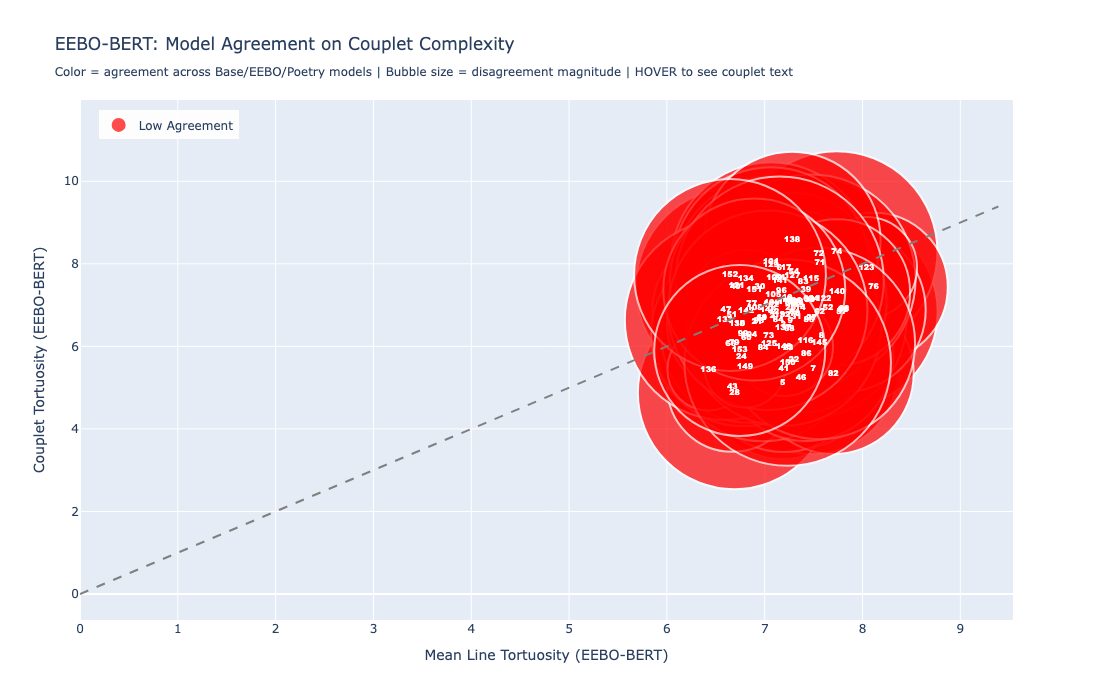


MODEL AGREEMENT ANALYSIS

High agreement sonnets: 0
Medium agreement sonnets: 0
Low agreement sonnets: 102

MOST CONTROVERSIAL COUPLETS (models disagree most)

  Sonnet 154: StdDev=2.124
    Ratios: Base=5.02 EEBO=1.26 Poetry=1.43
    Couplet:
        Came there for cure and this by that I prove,
        Love’s fire heats water, water cools not love.

  Sonnet  78: StdDev=1.798
    Ratios: Base=4.15 EEBO=1.08 Poetry=0.99
    Couplet:
        But thou art all my art, and dost advance
        As high as learning, my rude ignorance.

  Sonnet  32: StdDev=1.541
    Ratios: Base=3.56 EEBO=0.83 Poetry=0.97
    Couplet:
        But since he died and poets better prove,
        Theirs for their style I’ll read, his for his love’.

  Sonnet 112: StdDev=1.470
    Ratios: Base=3.68 EEBO=1.16 Poetry=1.11
    Couplet:
        You are so strongly in my purpose bred,
        That all the world besides methinks are dead.

  Sonnet 113: StdDev=1.446
    Ratios: Base=3.63 EEBO=1.11 Poetry=1.13
    Coup

In [16]:
# Option 2: Model Agreement Visualization
# Show which sonnets all models agree/disagree on WITH COUPLET TEXT

# Merge data from all three models
merged = results['base_layer3'][['sonnet', 'semantic_tortuosity', 'couplet_tortuosity']].copy()
merged.columns = ['sonnet', 'base_mean', 'base_couplet']

eebo_temp = results['eebo_semantic'][['sonnet', 'mean_line_tortuosity', 'couplet_tortuosity']].copy()
eebo_temp.columns = ['sonnet', 'eebo_mean', 'eebo_couplet']
merged = merged.merge(eebo_temp, on='sonnet')

poetry_temp = results['poetry_semantic'][['sonnet', 'mean_line_tortuosity', 'couplet_tortuosity']].copy()
poetry_temp.columns = ['sonnet', 'poetry_mean', 'poetry_couplet']
merged = merged.merge(poetry_temp, on='sonnet')

# Calculate couplet ratios for each model
merged['base_ratio'] = merged['base_couplet'] / merged['base_mean']
merged['eebo_ratio'] = merged['eebo_couplet'] / merged['eebo_mean']
merged['poetry_ratio'] = merged['poetry_couplet'] / merged['poetry_mean']

# Calculate standard deviation across models (disagreement measure)
merged['ratio_std'] = merged[['base_ratio', 'eebo_ratio', 'poetry_ratio']].std(axis=1)
merged['ratio_mean'] = merged[['base_ratio', 'eebo_ratio', 'poetry_ratio']].mean(axis=1)

# Add couplet text
merged['couplet_text'] = merged['sonnet'].apply(lambda x: couplet_lookup.get(x, "Not available"))

# Categorize by agreement level
merged['agreement'] = pd.cut(merged['ratio_std'], 
                             bins=[0, 0.05, 0.1, 1.0], 
                             labels=['High Agreement', 'Medium Agreement', 'Low Agreement'])

fig = go.Figure()

# Color by agreement level
agreement_colors = {
    'High Agreement': 'rgb(0, 176, 80)',      # Green
    'Medium Agreement': 'rgb(255, 192, 0)',   # Yellow/Orange  
    'Low Agreement': 'rgb(255, 0, 0)'        # Red
}

for agreement_level in ['High Agreement', 'Medium Agreement', 'Low Agreement']:
    group_data = merged[merged['agreement'] == agreement_level]
    
    fig.add_trace(go.Scatter(
        x=group_data['eebo_mean'],
        y=group_data['eebo_couplet'],
        mode='markers+text',
        marker=dict(
            size=group_data['ratio_std'] * 200 + 10,  # Size = disagreement
            color=agreement_colors[agreement_level],
            opacity=0.7,
            line=dict(width=2, color='white')
        ),
        text=group_data['sonnet'],
        textposition='middle center',
        textfont=dict(size=8, color='white', family='Arial Black'),
        name=agreement_level,
        hovertemplate='<b>Sonnet %{text}</b><br>' +
                      '<i>%{customdata[2]}</i><br><br>' +  # Couplet text
                      'Mean Line: %{x:.3f}<br>' +
                      'Couplet: %{y:.3f}<br>' +
                      'Model StdDev: %{customdata[0]:.3f}<br>' +
                      'Avg Ratio: %{customdata[1]:.3f}<br>' +
                      '<b>Ratios:</b> Base=%{customdata[3]:.2f}, EEBO=%{customdata[4]:.2f}, Poetry=%{customdata[5]:.2f}' +
                      '<extra></extra>',
        customdata=group_data[['ratio_std', 'ratio_mean', 'couplet_text', 'base_ratio', 'eebo_ratio', 'poetry_ratio']].values
    ))

# Add diagonal
max_val = max(merged['eebo_mean'].max(), merged['eebo_couplet'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    line=dict(color='gray', dash='dash', width=2),
    showlegend=False,
    hoverinfo='skip'
))

fig.update_layout(
    title='EEBO-BERT: Model Agreement on Couplet Complexity<br>' +
          '<sub>Color = agreement across Base/EEBO/Poetry models | Bubble size = disagreement magnitude | HOVER to see couplet text</sub>',
    xaxis_title='Mean Line Tortuosity (EEBO-BERT)',
    yaxis_title='Couplet Tortuosity (EEBO-BERT)',
    height=700,
    width=900,
    hovermode='closest',
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.9)')
)

fig.show()

# Print interesting cases WITH COUPLET TEXT
print("\n" + "="*80)
print("MODEL AGREEMENT ANALYSIS")
print("="*80)
print(f"\nHigh agreement sonnets: {len(merged[merged['agreement'] == 'High Agreement'])}")
print(f"Medium agreement sonnets: {len(merged[merged['agreement'] == 'Medium Agreement'])}")
print(f"Low agreement sonnets: {len(merged[merged['agreement'] == 'Low Agreement'])}")

print("\n" + "="*80)
print("MOST CONTROVERSIAL COUPLETS (models disagree most)")
print("="*80)
top_disagreement = merged.nlargest(10, 'ratio_std')[['sonnet', 'ratio_std', 'base_ratio', 'eebo_ratio', 'poetry_ratio', 'couplet_text']]
for idx, row in top_disagreement.iterrows():
    # Remove HTML line breaks and display nicely
    couplet_lines = row['couplet_text'].replace('<br>', '\n        ')
    print(f"\n  Sonnet {row['sonnet']:3d}: StdDev={row['ratio_std']:.3f}")
    print(f"    Ratios: Base={row['base_ratio']:.2f} EEBO={row['eebo_ratio']:.2f} Poetry={row['poetry_ratio']:.2f}")
    print(f"    Couplet:")
    print(f"        {couplet_lines}")

print("\n" + "="*80)
print("MOST AGREED-UPON COUPLETS (models consensus)")
print("="*80)
low_disagreement = merged.nsmallest(10, 'ratio_std')[['sonnet', 'ratio_std', 'base_ratio', 'eebo_ratio', 'poetry_ratio', 'couplet_text']]
for idx, row in low_disagreement.iterrows():
    couplet_lines = row['couplet_text'].replace('<br>', '\n        ')
    print(f"\n  Sonnet {row['sonnet']:3d}: StdDev={row['ratio_std']:.3f}")
    print(f"    Ratios: Base={row['base_ratio']:.2f} EEBO={row['eebo_ratio']:.2f} Poetry={row['poetry_ratio']:.2f}")
    print(f"    Couplet:")
    print(f"        {couplet_lines}")

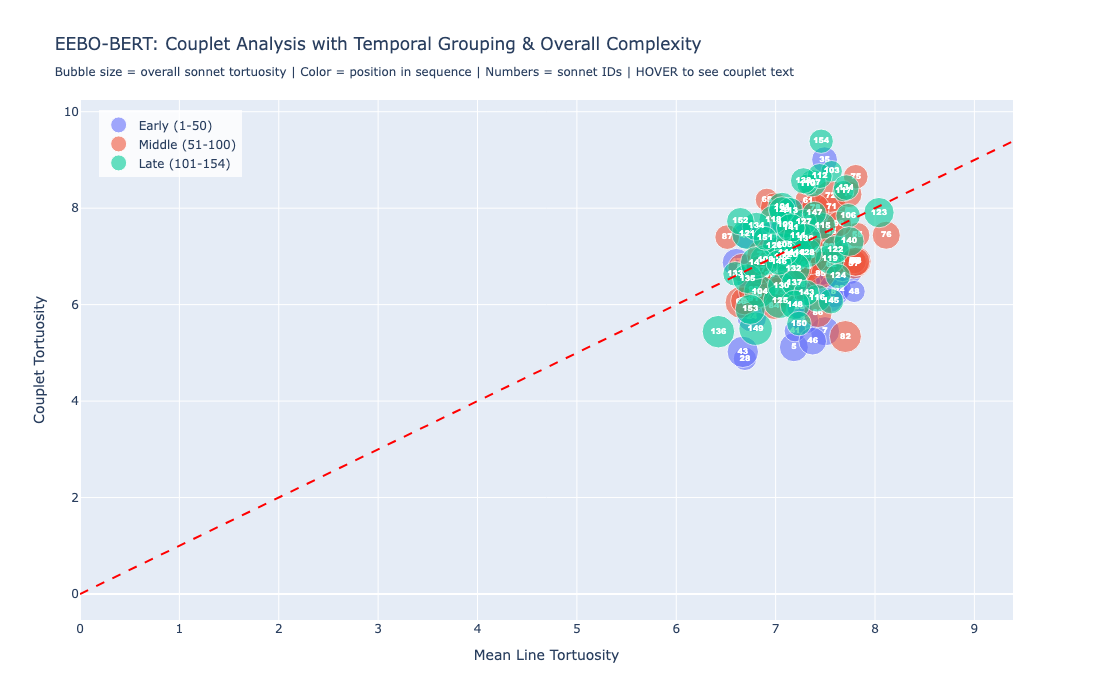

Bubble Chart Legend:
  • Bubble SIZE = Overall sonnet complexity (larger = more complex)
  • Bubble COLOR = Temporal position (early/middle/late in sequence)
  • Number inside = Sonnet number (for precise identification)
  • HOVER = See actual couplet text + metrics
  • Above red line = Couplet more complex than average line
  • Below red line = Couplet less complex than average line


In [17]:
# Option 1: Bubble Chart with Multiple Encoded Variables
# Size = overall tortuosity, Color = temporal position, Labels = sonnet numbers, HOVER = couplet text

fig = go.Figure()

# Prepare data for EEBO-BERT (as example - can do for all models)
df = results['eebo_semantic'].copy()
df['temporal_group'] = pd.cut(df['sonnet'], bins=[0, 50, 100, 154], labels=['Early (1-50)', 'Middle (51-100)', 'Late (101-154)'])
df['couplet_ratio'] = df['couplet_tortuosity'] / df['mean_line_tortuosity']
df['is_outlier'] = (df['couplet_ratio'] > df['couplet_ratio'].quantile(0.9)) | (df['couplet_ratio'] < df['couplet_ratio'].quantile(0.1))

# Add couplet text to dataframe
df['couplet_text'] = df['sonnet'].apply(lambda x: couplet_lookup.get(x, "Not available"))

# Color mapping for temporal groups
color_map = {'Early (1-50)': 'rgb(99, 110, 250)', 
             'Middle (51-100)': 'rgb(239, 85, 59)', 
             'Late (101-154)': 'rgb(0, 204, 150)'}

for group in ['Early (1-50)', 'Middle (51-100)', 'Late (101-154)']:
    group_data = df[df['temporal_group'] == group]
    
    fig.add_trace(go.Scatter(
        x=group_data['mean_line_tortuosity'],
        y=group_data['couplet_tortuosity'],
        mode='markers+text',
        marker=dict(
            size=group_data['overall_tortuosity'] * 8,  # Size encodes overall complexity
            color=color_map[group],
            opacity=0.6,
            line=dict(width=1, color='white')
        ),
        text=group_data['sonnet'],
        textposition='middle center',
        textfont=dict(size=8, color='white', family='Arial Black'),
        name=group,
        hovertemplate='<b>Sonnet %{text}</b><br>' +
                      '<i>%{customdata[1]}</i><br><br>' +  # Couplet text with line break
                      'Mean Line: %{x:.3f}<br>' +
                      'Couplet: %{y:.3f}<br>' +
                      'Overall: %{customdata[0]:.3f}<br>' +
                      'Ratio: %{customdata[2]:.2f}<extra></extra>',
        customdata=group_data[['overall_tortuosity', 'couplet_text', 'couplet_ratio']].values
    ))

# Add diagonal reference line
max_val = max(df['mean_line_tortuosity'].max(), df['couplet_tortuosity'].max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    line=dict(color='red', dash='dash', width=2),
    showlegend=False,
    hoverinfo='skip',
    name='y=x'
))

fig.update_layout(
    title='EEBO-BERT: Couplet Analysis with Temporal Grouping & Overall Complexity<br>' +
          '<sub>Bubble size = overall sonnet tortuosity | Color = position in sequence | Numbers = sonnet IDs | HOVER to see couplet text</sub>',
    xaxis_title='Mean Line Tortuosity',
    yaxis_title='Couplet Tortuosity',
    height=700,
    width=900,
    hovermode='closest',
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)')
)

fig.show()

print("Bubble Chart Legend:")
print("  • Bubble SIZE = Overall sonnet complexity (larger = more complex)")
print("  • Bubble COLOR = Temporal position (early/middle/late in sequence)")
print("  • Number inside = Sonnet number (for precise identification)")
print("  • HOVER = See actual couplet text + metrics")
print("  • Above red line = Couplet more complex than average line")
print("  • Below red line = Couplet less complex than average line")

## Enhanced Couplet Visualizations

More information-rich visualizations with preserved sonnet labels

## Couplet Analysis

Analyze whether the final couplet (last 2 lines) is more or less complex than the average line in each sonnet.

In [19]:
# Load sonnets
sonnets_path = Path('../corpus_samples/shakespeare_sonnets_parsed.jsonl')
sonnets = []
with open(sonnets_path, 'r') as f:
    for line in f:
        sonnets.append(json.loads(line))

sonnet_lookup = {s['sonnet_number']: s for s in sonnets}
print(f"✓ Loaded {len(sonnets)} sonnets")

✓ Loaded 154 sonnets


### Detailed Scansion Analysis - All Metrical Variants

Explore all possible scansions for lines. The notation follows traditional hand-scansion style:
- **Bold** = stressed syllable
- `|` = foot boundary
- Pattern shows stress sequence (0 = unstressed, 1 = stressed)

### Full Sonnet Scansion - All Lines with Variants

Scan an entire sonnet to see metrical patterns across all 14 lines

### Corpus-Wide Metrical Analysis

Analyze metrical complexity across all 154 sonnets